<a href="https://colab.research.google.com/github/khushbooG9/Pointer-Networks-Using-Fast-Weights/blob/master/PtrFW_boundary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All the dependencies needed for the implementation

In [0]:
import tensorflow as tf 
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
#import tensorflow.contrib.eager as tfe
import numpy as np 
import random
tf.enable_eager_execution()


Fastweights module to be called into Pointer Networks module as encoder and decoder


In [0]:
class fastweights(tf.keras.Model):
	def __init__(self,elemnum , batch_size=128, decay_rate = 0.9, learning_rate = 0.5, hidden_size=512):
		super(fastweights, self).__init__()
		self.batch_size = batch_size
		self.DR = decay_rate
		self.LR = learning_rate
		self.hidden_size = hidden_size
		self.W_x = tf.Variable(tf.random_uniform([elemnum, hidden_size], -np.sqrt(2/elemnum), np.sqrt(2/elemnum)), dtype=tf.float32)
		self.B_x = tf.Variable(tf.zeros(hidden_size), dtype=tf.float32)
		self.W_h = tf.Variable(initial_value = 0.5 * np.identity(hidden_size), dtype = tf.float32)
		self.W_y = tf.Variable(tf.random_uniform([hidden_size, elemnum], -np.sqrt(2/hidden_size), np.sqrt(2/hidden_size)), dtype = tf.float32)
		self.B_y = tf.Variable(tf.zeros(elemnum), dtype= tf.float32)
		self.scale = tf.Variable(tf.ones(hidden_size), dtype = tf.float32)
		self.shift = tf.Variable(tf.zeros(hidden_size), dtype = tf.float32) 
		#initial values of A and H matricies
		self.A = tf.zeros([self.batch_size, self.hidden_size,self.hidden_size], dtype = tf.float32)
		self.H = tf.zeros([self.batch_size, self.hidden_size], dtype = tf.float32)
    
	def call(self,X,H, S=1):
		X = tf.cast(X, tf.float32)
		for t in range(tf.shape(X)[1]):
			#first hidden state, A and H_s are  zero at this point so the part A(t)H_s(t+1) becomes zero
      #when used as decoder in pointer nets, starting H needs to be last encoder hidden state, 
      #while for encoder it's still zero, just added H in the argument to facilitate LSTMCell like functioninh
			self.H = tf.nn.relu((tf.matmul(H,self.W_h))+(tf.matmul(X[:, t, :],self.W_x)+self.B_x))
			#reshaping to use it with A, to calculate the A(t)H_s(t+1)
			H_s = tf.reshape(self.H, [self.batch_size, 1, self.hidden_size])
			#Initial A for this particular time step: A(t) = decay*A(t-1)+ learning*h(t)h(t).T
			#self.A = tf.add((tf.scalar_mul(self.DR, self.A)),(tf.batch_matmul(tf.transpose(self.H_s, [0,2,1]),self.H_s)))
			self.A = (tf.scalar_mul(self.DR, self.A))+ tf.scalar_mul(self.LR,(tf.matmul(tf.transpose(H_s, [0,2,1]),H_s)))
			#inner loop for fast weights, tfor S steps
			for _ in range(S):
				#calculating H_s without the non linearity first, so we can use linear normalization 
				H_s = tf.reshape(tf.matmul(self.H,self.W_h),tf.shape(H_s)) + tf.reshape(tf.matmul(X[:,t,:],self.W_x)+self.B_x,tf.shape(H_s)) + tf.matmul(H_s, self.A)
				#Applying Layer Normalization 
				mean, var = tf.nn.moments(H_s, axes =2, keep_dims = True)
				H_s = (self.scale*(H_s - mean))/(tf.sqrt(var + 1e-5) + self.shift)
				#applying non linearity
				H_s = tf.nn.relu(H_s)
			self.H = tf.reshape(H_s,[self.batch_size, self.hidden_size])
		finallayer = tf.matmul(self.H, self.W_y) + self.B_y
		return finallayer, self.H

Please make sure to have Hiddensize = numblend units while invoking PtrNetFW

In [0]:
class PtrNetFW(tf.keras.Model):
  def __init__(self, maxlen, batchsize, numblendunits=512, hiddensize=512): #J- input length, B-batch size, H-hidden units for lstm, D-blend units(basically size of V, same as hiddensize) respectively
    super(PtrNetFW, self).__init__()
    self.maxlen = maxlen
    self.batchsize = batchsize
    self.hiddensize = hiddensize
    self.blendunits = numblendunits
    self.targetsize = 2 # (start,end) size 2 I
    self.input_dim = 1 # ignored, S-size of each vector
    self.generationsym = 20.0 #Used as starting value
    self.init = tf.random_normal_initializer(-0.08, 0.08)
    self.encoder = fastweights(hiddensize, batch_size = batchsize,hidden_size=hiddensize)
    self.decoder = fastweights(hiddensize, batch_size = batchsize,hidden_size=hiddensize)
    self.W_e = tf.Variable(tf.random_uniform([self.input_dim, hiddensize], -0.08, 0.08), dtype=tf.float32)
    self.B_e = tf.Variable(tf.random_uniform([batchsize, hiddensize], -0.08, 0.08), dtype=tf.float32)
    #For mapping the raw input to LSTM dimensions
    self.W_d_in = tf.Variable(tf.random_uniform([self.input_dim, hiddensize], -0.08, 0.08), dtype=tf.float32)
    self.B_d_in = tf.Variable(tf.random_uniform([batchsize, hiddensize], -0.08, 0.08), dtype=tf.float32)
    self.W1 = tf.Variable(tf.random_uniform([ hiddensize, numblendunits], -0.08, 0.08), dtype=tf.float32)
    self.W2 = tf.Variable(tf.random_uniform([hiddensize, numblendunits], -0.08, 0.08), dtype=tf.float32)
    self.B_ptr = tf.Variable(tf.random_uniform([batchsize, numblendunits], -0.08, 0.08), dtype=tf.float32)
    self.V = tf.Variable(tf.random_uniform([numblendunits, 1], -0.5, 0.5), dtype=tf.float32) #Dx1
    
    
  def call(self, X):
    #Encoder function
    e_state = tf.zeros([self.batchsize, self.hiddensize]) #self.encoder.zero_state(self.batchsize, tf.float32) #BxH 0 is starting state for RNN
    e_states = []
    for i in range(self.maxlen):
      X_ = tf.cast(X[:, i:i+1], tf.float32) #BxS , step throuh input one at a time
      #Mapping raw input to LSTM dimensions
      #print(tf.matmul(X_, self.W_e).shape, self.B_e.shape)
      cell_input = tf.nn.elu(tf.matmul(X_, self.W_e) + self.B_e)  #BxH
      cell_input = tf.expand_dims(cell_input, 1)
      Y, e_state = self.encoder(cell_input, e_state) # Has c as BxH, h as BxH
      e_states.append(e_state) # no. of c and h are J in the list
      
      
    #Decoder function
    #Different special symbol, should not be from actual data
    startsymbol = tf.constant(self.generationsym, shape=(self.batchsize, self.input_dim), dtype = tf.float32) #BxS
    #First decoder state is last encoder state
    d_state = e_states[-1]
    ptr_Ys = []
    ptr_Y_dists = []
    X_ = startsymbol #BxS
    #print(X_)
    for i in range(self.targetsize):
      cell_input = tf.nn.elu(tf.matmul(tf.cast(X_,  tf.float32), self.W_d_in)+ self.B_d_in)
      cell_input = tf.expand_dims(cell_input, 1)
      Y, d_state = self.decoder(cell_input, d_state)  #Y = BxH d_state.c = BXH
      index_predists = []
      #Loop over each input to get softmax distribution
      d_part = tf.matmul(d_state, self.W2)  #BxD
      e_parts = []
      for index in range(self.maxlen):
        
        #J's of Bx1, flattening to  JxB
        e_part = tf.matmul(e_states[index] , self.W1)  #BxD
        rawblend = tf.nn.elu(e_part + d_part + self.B_ptr) #BxD
        scaled_blend = tf.matmul(rawblend, self.V) #Bx1
        index_predist = tf.reshape(scaled_blend, (self.batchsize,))
        e_parts.append(e_part)
        index_predists.append(index_predist)
        
      idx_predist = tf.transpose(tf.stack(index_predists))  #BxJ
      idx_dist = tf.nn.softmax(idx_predist, dim=1) #BxJ
      ptr_Y_dists.append(idx_dist)
      idx = tf.argmax(idx_dist, 1) #over last dimension, reduce rank #B
      
      #Pull out the input from index
      emb = tf.nn.embedding_lookup(tf.transpose(X), idx) #BxB
      ptr_Y_raw = tf.diag_part(emb) #B
      
      ptr_Y = tf.reshape(ptr_Y_raw, (self.batchsize, self.input_dim)) #BxS
      ptr_Ys.append(ptr_Y)
      X_ = ptr_Y #output goes back as input to decoder
    
    idx_distributions = tf.stack(ptr_Y_dists) #IxBxJ 
    return idx_distributions

Functions to generate the data sets . This generate low-high-low sequences where low is range [0,5] and high is range [6,10] integers. You can change the values to play around the code. 
This can be sclaled by any user to other lengths and values for the subsequences of high-low values

In [0]:
def single_seq(length = 30, minlen = 5, maxlen=10):
  left = [(random.randint(1, 5)) for x in range(random.randint(minlen, maxlen))]
  mid = [(random.randint(6, 10)) for x in range(random.randint(minlen, maxlen))]
  right = [random.randint(1, 5) for x in range(random.randint(minlen, maxlen))]
  seq = left + mid + right
  seq = seq + ([0] * (length - len(seq)))
  #return index positions of the start and end of the middle sequence
  return (seq, len(left), len(left) + len(mid)-1)

def onehot(len, idx):
  oh = np.zeros([len])
  oh[idx] = 1
  return oh

def set_of_seq(n, l, minl, maxl):
  data = []
  starts = []
  ends = []
  datadict = {}
  for i in range(n):
    seq, ind_start, ind_end = single_seq(l, minl, maxl)#J, J,J
    data.append(seq)
    starts.append(onehot(len(seq),ind_start))
    ends.append(onehot(len(seq),ind_end))
  datadict[0] = np.stack(data) #BxJ
  datadict[1] = np.stack([np.stack(starts), np.stack(ends)]) 
  return datadict

Getting the training, validation and testing set ready. 

**For 3rd experiment, min and max length for training is 5 and 10, while for validation and testing it's 11 and 20.** This will actually determine the generalization ability of the network as it won't see any example of high values subsequence with length more than 10. But while testing it will predict the boundary indexes of the high value subsequence with length from 11 to 20.

**Make sure to keep maxlen =3*max high value subsequence length** 

Currently all 3 sets are set up to have equal number of samples. train is the training set, valid is the test set 1 and test is actually the test set 2. Due to random generator function of the sequences, no overfitting was observed. 

In [0]:
maxlen = 60
samples = 1000
train = set_of_seq(samples, maxlen, 5, 10) #Training set
valid = set_of_seq(samples, maxlen, 5, 10) #Test set with same length for high subsequences
test = set_of_seq(samples, maxlen, 11, 20) #Test set with different length for high subsequences


Please make sure to keep the hidden and blend equal. Setting up the optimizer and intitalizing the PtrNetFW module. 
**Default parameters - batch =100, hiddensize =num blendunits = 256, AdamOptimizer with learning rate of 0.005**

In [0]:
optimizer = tf.train.AdamOptimizer(0.005)
batch= 100
blend =hidden= 256
pn = PtrNetFW(maxlen, batch, blend, hidden)

**Make sure to switch to GPU mode for the training**   Go to Runtime tab. Select change runtime to Python 3 and Accelator as GPU.

In [0]:
trainloss = []
trainbatchloss = []
validloss = []
validbatchloss = []
testloss = []
testbatchloss = []
numepochs = 500
with tf.device("/gpu:0"):
  #l = 0
  for epoch in range(numepochs):
    print("Epoch number :", epoch)
    for i in range(0, samples, batch):
      l = 0
      vl = 0
      tl = 0
      x = train[0][i:i+batch, :]
      y = train[1][:,i:i+batch,:]
      with tf.GradientTape() as tape:
        pred = pn(x)
        l += tf.sqrt(tf.reduce_mean(tf.pow(pred-y, 2.0)))
        trainloss.append(l)
      var = pn.variables
      grads = tape.gradient(l, var)
      optimizer.apply_gradients(zip(grads, var), global_step=tf.train.get_or_create_global_step())
      vx = valid[0][i:i+batch, :]
      vy = valid[1][:,i:i+batch,:]
      vpred = pn(vx)
      vl += tf.sqrt(tf.reduce_mean(tf.pow(vpred-vy, 2.0)))
      tx = test[0][i:i+batch, :]
      ty = test[1][:,i:i+batch,:]
      tpred = pn(tx)
      tl += tf.sqrt(tf.reduce_mean(tf.pow(tpred-ty, 2.0)))
      validloss.append(vl)
      testloss.append(tl)
      if i==500:
        print("Validation set loss at batch : "+ str(i)+" is "+str(vl.numpy()))
        print("Test set loss at batch : "+ str(i)+" is "+str(tl.numpy()))
    bl = (l/batch)
    trainbatchloss.append(bl)
    vbl = (vl/batch)
    validbatchloss.append(vbl)
    tbl = (tl/batch)
    testbatchloss.append(tbl)
    print("Epoch {:03d}/{:03d} completed \t - \ total average batch loss: {:.9f}".format((epoch+1), numepochs, tf.sqrt(tf.reduce_mean(tf.pow(pred-y, 2.0)))))
  print("Final loss for training  set: {:.9f}".format(tf.sqrt(tf.reduce_mean(tf.pow(pred-y, 2.0)))))
      
    
  

Epoch number : 0
Validation set loss at batch : 500 is 0.11914124
Test set loss at batch : 500 is 0.12161095
Epoch 001/600 completed 	 - \ total average batch loss: 0.118939519
Epoch number : 1
Validation set loss at batch : 500 is 0.1184622
Test set loss at batch : 500 is 0.12033549
Epoch 002/600 completed 	 - \ total average batch loss: 0.125034288
Epoch number : 2
Validation set loss at batch : 500 is 0.11843989
Test set loss at batch : 500 is 0.118157685
Epoch 003/600 completed 	 - \ total average batch loss: 0.113583006
Epoch number : 3
Validation set loss at batch : 500 is 0.104000315
Test set loss at batch : 500 is 0.11453787
Epoch 004/600 completed 	 - \ total average batch loss: 0.109741963
Epoch number : 4
Validation set loss at batch : 500 is 0.0987876
Test set loss at batch : 500 is 0.10362526
Epoch 005/600 completed 	 - \ total average batch loss: 0.093458913
Epoch number : 5
Validation set loss at batch : 500 is 0.07325337
Test set loss at batch : 500 is 0.09163654
Epoch 

KeyboardInterrupt: ignored

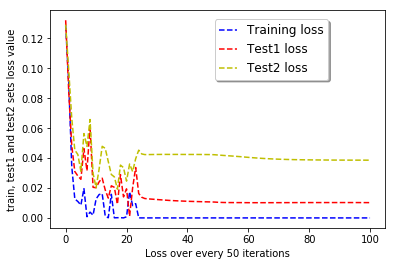

Text(0.5, 0, 'No. of batches over iterations')

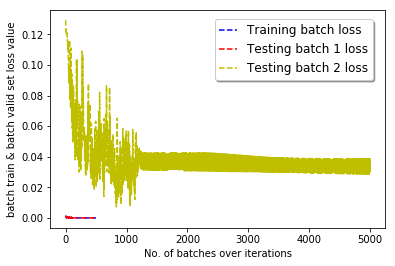

In [0]:

plt.plot(trainloss[::50],'b--', validloss[::50], 'r--', testloss[::50], 'y--')
plt.legend(('Training loss', 'Test1 loss' , 'Test2 loss'),
           shadow=True, loc=(0.49, 0.68), handlelength=1.5, fontsize=12)

plt.ylabel('train, test1 and test2 sets loss value')
plt.xlabel('Loss over every 50 iterations')

plt.show()

plt.plot(trainbatchloss, 'b--', validbatchloss, 'r--', testloss, 'y--')
plt.legend(('Training batch loss', 'Testing batch 1 loss', 'Testing batch 2 loss'),
           shadow=True, loc=(0.49, 0.68), handlelength=1.5, fontsize=12)

plt.ylabel('batch train & batch valid set loss value')
plt.xlabel('No. of batches over iterations')

Actually testing the accuracy of generalised on different length subsequences in low-high-low for the high part

In [0]:

count = 0
for i in range(0, samples,batch):
  l = 0
  x = test[0][i:i+batch, :]
  y = test[1][:,i:i+batch,:]
  testpred = pn(x)
  prediction.append(testpred)
  l+= tf.sqrt(tf.reduce_mean(tf.pow(testpred-y, 2.0)))
  for k in range(batch):
    first = np.argmax(testpred[0,k,:])
    second = np.argmax(testpred[1,k,:])
    print("For the sequence :", test[0][k+i,:])
    print("Predicted Indexes: (" + str(first) + "," + str(second)+") ")
    print("Actual boundary indexes :",np.where(test[1][0,k+i,:])[0], np.where(test[1][1,k+i,:])[0])
    if np.where(test[1][0,k+i,:])[0]==first and np.where(test[1][1,k+i,:])[0] == second:
      count+=1
      
print("Correct prediction counts:" , count)
print("Prediction accuracy :" , count/samples)


For the sequence : [ 3  4  4  4  4  2  1  4  1  2  4  5  4  3  4 10 10  7  9 10 10 10 10  7
  6 10  4  5  3  3  1  2  5  2  2  3  3  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
Predicted Indexes: (15,25) 
Actual boundary indexes : [15] [25]
For the sequence : [ 4  4  5  1  4  2  3  2  2  4  1  1  2  3  4  3  5  1  4  3  7  9  9  9
  8 10  9  8  9  9  6  9 10  8 10  9  9  6  6  2  1  1  2  5  5  4  1  1
  5  4  3  2  5  4  4  1  5  0  0  0]
Predicted Indexes: (20,38) 
Actual boundary indexes : [20] [38]
For the sequence : [ 5  1  4  5  4  4  4  5  2  1  2 10  6  7  6  8 10  9  8  8  8  7  7  7
 10  9  9  3  1  2  4  2  5  3  1  2  2  4  1  1  2  5  3  2  3  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
Predicted Indexes: (11,26) 
Actual boundary indexes : [11] [26]
For the sequence : [ 2  5  2  3  3  4  3  5  2  2  5  2  5  5  2  2  1  5  4  7  8 10  9  8
 10  9  7  8  9  8  9  6  6 10  6 10  6  6  5  4  2  4  1  3  2  3  4  1
  2  2  0  0  0  0  0  0  0  0  0 